An Interactive Tutorial on Numerical Optimization https://www.benfrederickson.com/numerical-optimization/

# Paquetes

In [87]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import sympy as sym

import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from tqdm import tqdm

# Datos de ejemplo

In [88]:
diabetes = load_diabetes()
features = list(diabetes.feature_names)
features
data_set = pd.DataFrame(
    diabetes.data, 
    columns = diabetes.feature_names
)
data_set['y'] = diabetes.target

Y = MX + B

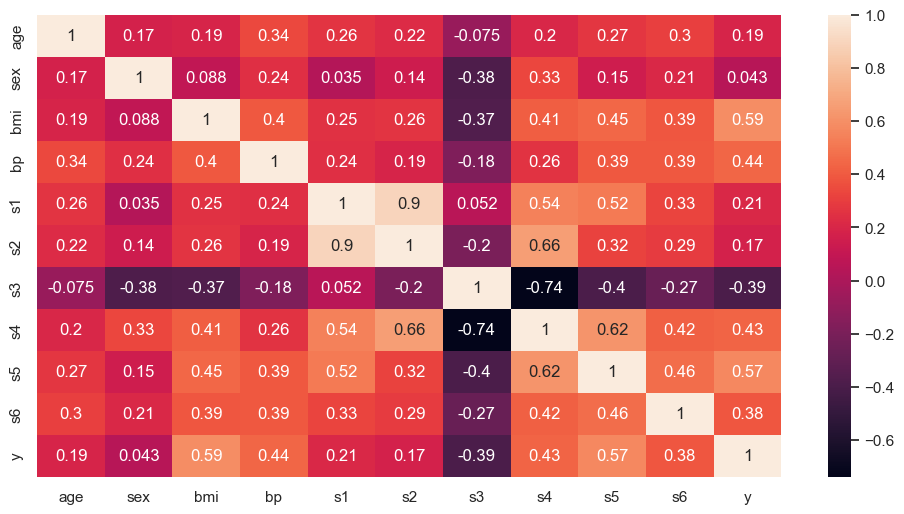

In [89]:
plt.figure(figsize=(12,6))
sns.heatmap(
    data_set.corr(),
    annot=True
)
plt.show()

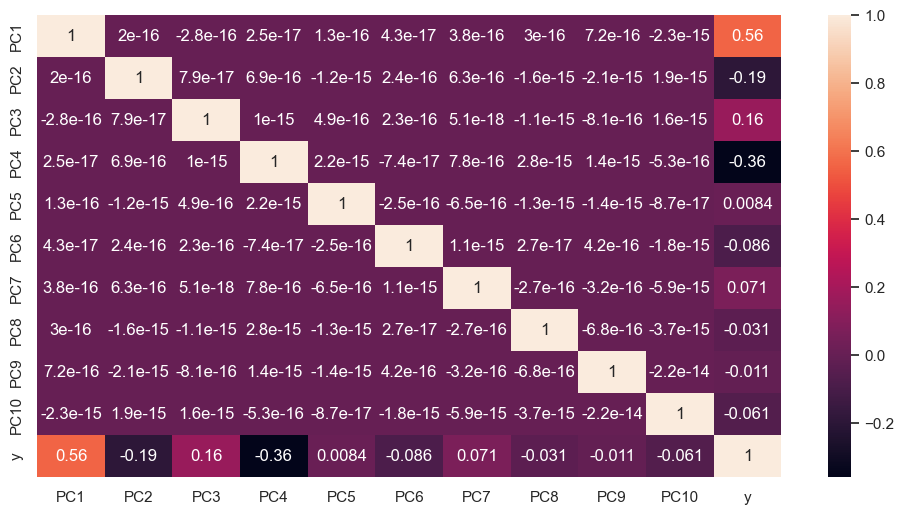

In [90]:
pca = PCA()
pca.fit(data_set[features].values)
data_set_pca = data_set.copy()
scaler = StandardScaler()
data_set_pca[features] = scaler.fit_transform(data_set_pca[features])
data_set_pca[features] = pca.transform(data_set[features].values)

data_set_pca['y'] = data_set['y']
data_set_pca.columns   = [f'PC{i+1}' for i in range(len(features))] + ['y']

plt.figure(figsize=(12,6))
sns.heatmap(
    data_set_pca.corr(),
    annot=True
)
plt.show()

# Y vs PC1

<Axes: xlabel='PC1', ylabel='y'>

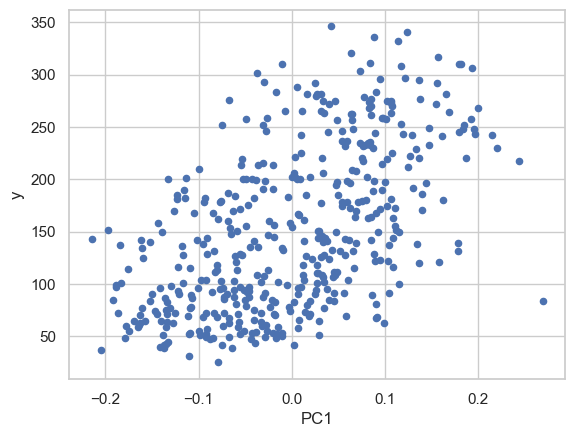

In [91]:
data_set_pca[['PC1','y']].plot.scatter(x='PC1',y='y')

# Loss function

Mean Squared Error

In [92]:
# Definir variables simbólicas
n, i, y_i, y_hat_i = sym.symbols('n i y_i y_hat_i')

# Definir la ecuación del MSE
MSE = (sym.Sum((y_i - y_hat_i)**2, (i, 1, n)))*(1 / n)

# Mostrar la ecuación en formato LaTeX

display(Math('MSE = '+sym.latex(MSE)))

<IPython.core.display.Math object>

La ecuación de la recta es la siguiente

In [93]:
sym.init_printing()
w0, w1, x = sym.symbols("w0 w1 x")

y = w1*x + w0
display(Math('y_{hat} = '+sym.latex(y)))

<IPython.core.display.Math object>

Entonces $y_{hati}$ lo remplazamos en la función de costo MSE:

MSE(w0,w1)

In [94]:
# Definir variables simbólicas
n, i, y_i, w0, w1, x_i = sym.symbols('n i y_i w0 w1 x_i')

# Definir la ecuación del MSE
MSE = (sym.Sum((y_i - (w0 + w1*x_i))**2, (i, 1, n)))*(1 / n)

# Mostrar la ecuación en formato LaTeX

display(Math('MSE = '+sym.latex(MSE)))

<IPython.core.display.Math object>

Para usar el método del gradiente descendente se usa el cálculo diferencial multivariable para cálcular las derivadas parciales del MSE respecto $w_{0}$ y $w_{1}$.

Cálculemos el gradiente!

In [95]:
# derivadas parciales
dMSE_dw0 = sym.diff(MSE, w0)
display(Math('∂_{MSE}/∂_{w_0} = '+sym.latex(dMSE_dw0)))

dMSE_dw1 = sym.diff(MSE, w1)
display(Math('∂_{MSE}/∂_{w_1} = '+sym.latex(dMSE_dw1)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Utilizando el gradiente descendente estocástico

In [96]:
X = data_set_pca['PC1'].values
Y = data_set_pca['y'].values
n = len(X)

In [97]:
n

In [98]:
def gradient(x, y, n, w0, w1):
    # en este caso n es el batch size
    w0 = 2*w0 + 2*w1*x - 2*y
    w0 = np.sum(w0)/n

    w1 = -2*x*(-w0-w1*x+y)
    w1 = np.sum(w1)/n

    return w0, w1

In [236]:
lr = 0.3
epochs = 100
batch_size = 32
# beta = 0.8

# SGD

In [237]:
# inicializacion aleatoria de los gradientes
w0, w1 = np.random.standard_normal(2)

# v0 = 0
# v1 = 0

# las actualizaciones pesos
historical_w0 = []
historical_w1 = []

# aca se guarda el decrecimiento del lr
historical_lr = []
 
for i in tqdm(range(epochs)):
    for j in range(1000): # 1000 pasos de validacion
        # pesos historicos
        if i%2 == 0:
            historical_w0.append(w0)
            historical_w1.append(w1)

        # bache aleatorio 
        batch_idxs = np.random.choice(range(n),size=batch_size , replace=False)

        # datos de entrenamiento
        X_train = X[batch_idxs]
        y_train = Y[batch_idxs]

        # calculo del gradiente
        dMSE_dw0, dMSE_dw1 = gradient(
            x=X_train, 
            y=y_train, 
            n=batch_size, 
            w0=w0, 
            w1=w1
        )

        # learning rate scheduling
        lr_ = lr*0.9**i

        #el gradiente apunta en direccion donde la pendiente es más inclinada
        w0 = w0 - lr_*dMSE_dw0
        w1 = w1 - lr_*dMSE_dw1

        # se guarda el historico del cambio del lr
        historical_lr.append(lr_)

100%|██████████| 100/100 [00:06<00:00, 16.13it/s]


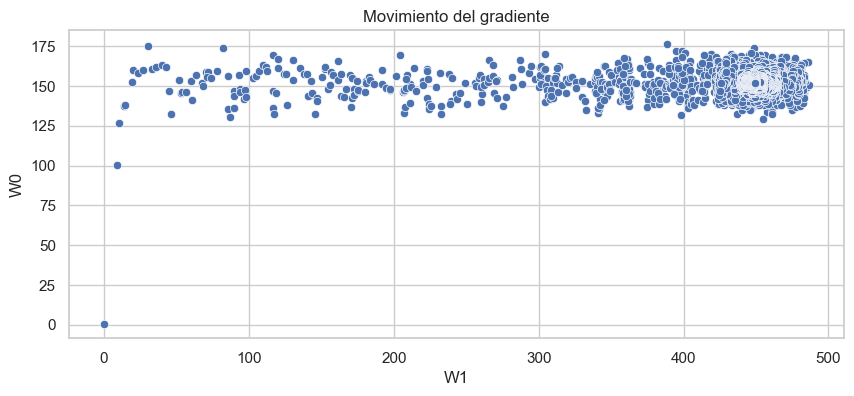

In [238]:
plt.figure(figsize=(10,4))
sns.scatterplot(
    x=historical_w1,
    y=historical_w0
)
plt.title('Movimiento del gradiente')
plt.xlabel('W1')
plt.ylabel('W0')
plt.show()

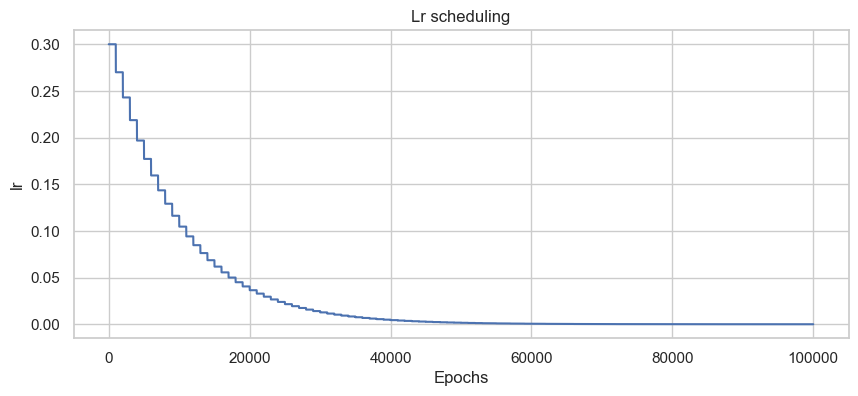

In [239]:
plt.figure(figsize=(10,4))
sns.lineplot(
    x=range(len(historical_lr)),
    y=historical_lr
)
plt.title('Lr scheduling')
plt.xlabel('Epochs')
plt.ylabel('lr')
plt.show()


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

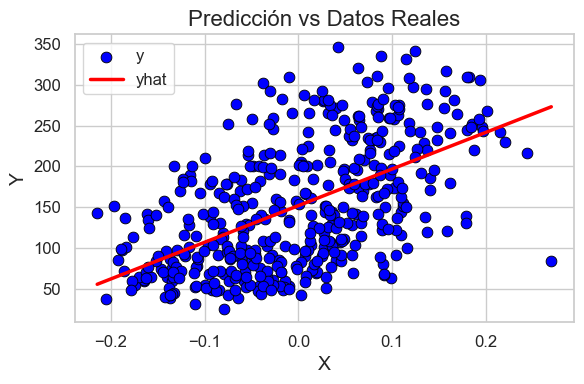

In [240]:
# con los pesos entrenados hacemos la prediccion
ypred= w0 + w1*X
error = round(mean_squared_error(y_true=Y, y_pred=ypred),4)
r2    = round(r2_score(y_true=Y, y_pred=ypred),4)

sym.init_printing()
X_ = sym.symbols("x")

y_ = round(w0,2) + round(w1,2)*X_ 
display(Math('f(x) = '+sym.latex(y_)))
display(Math('MSE = '+sym.latex(error)))
display(Math('R2 = '+sym.latex(r2)))

plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(
    x=X,
    y=Y,
    color='blue',
    label='y',
    s=60,  # Tamaño de los puntos
    edgecolor='black'
)

# Line plot
sns.lineplot(
    x=X,
    y=ypred,
    color='red',
    label='yhat',
    linewidth=2.5
)

# Títulos y etiquetas
plt.title('Predicción vs Datos Reales', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)

# Leyenda y otros ajustes
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()


# Usando Mínimos cuadrados ordinarios (OLS) usando statsmodels

In [241]:
# adding the constant term
x = sm.add_constant(X)
 
# performing the regression
# and fitting the model
result = sm.OLS(Y, x).fit()
 
# printing the summary table
# print(result.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

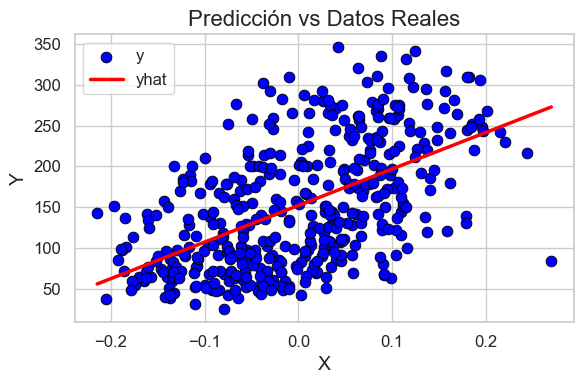

In [242]:
#estimacion y error
predicciones =result.get_prediction(exog=x).summary_frame(alpha=0.05)
ypred = predicciones['mean'].values
error = round(mean_squared_error(y_true=Y, y_pred=ypred),4)
r2    = round(r2_score(y_true=Y, y_pred=ypred),4)

# formulas
sym.init_printing()
X_ = sym.symbols("x")
w0, w1 = result.params
y_ = round(w0,2) + round(w1,2)*X_ 
display(Math('f(x) = '+sym.latex(y_)))
display(Math('MSE = '+sym.latex(error)))
display(Math('R2 = '+sym.latex(r2)))

plt.figure(figsize=(6, 4))
sns.set(style="whitegrid")

# Scatter plot
sns.scatterplot(
    x=X,
    y=Y,
    color='blue',
    label='y',
    s=60,  # Tamaño de los puntos
    edgecolor='black'
)

# Line plot
sns.lineplot(
    x=X,
    y=ypred,
    color='red',
    label='yhat',
    linewidth=2.5
)

# Títulos y etiquetas
plt.title('Predicción vs Datos Reales', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)

# Leyenda y otros ajustes
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
